Download the data
After download comment the command below

In [1]:
# !curl -O https://files.grouplens.org/datasets/movielens/ml-32m.zip
# !unzip ml-32m.zip
# !pip install -r requirements.txt

# Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.model_selection import train_test_split
import os
from datetime import datetime
import time

min_interactions = 5

# Load data

In [3]:
def load_data(data_dir="ml-32m"):
    """
    Load the MovieLens dataset into pandas dataframes.
    """
    print("Loading data...")
    start_time = time.time()

    # For large datasets, we can use chunksize parameter to load in batches
    # But for simplicity in this example, we'll load directly
    
    # Load ratings with proper dtypes to save memory
    ratings = pd.read_csv(os.path.join(data_dir, 'ratings.csv'), 
                          dtype={'userId': np.int32, 'movieId': np.int32, 
                                 'rating': np.float32, 'timestamp': np.int64})
    
    # Load movies
    movies = pd.read_csv(os.path.join(data_dir, 'movies.csv'),
                         dtype={'movieId': np.int32, 'title': str, 'genres': str})
    
    # Load tags (optional, depending on if you need them immediately)
    tags = pd.read_csv(os.path.join(data_dir, 'tags.csv'),
                       dtype={'userId': np.int32, 'movieId': np.int32, 
                              'tag': str, 'timestamp': np.int64})
    
    # Load links
    links = pd.read_csv(os.path.join(data_dir, 'links.csv'),
                        dtype={'movieId': np.int32, 'imdbId': str, 'tmdbId': str})
    
    elapsed = time.time() - start_time
    print(f"Data loaded in {elapsed:.2f} seconds")
    
    return ratings, movies, tags, links

In [4]:
ratings, movies, tags, links = load_data()

Loading data...
Data loaded in 16.37 seconds


# Basic Stats

In [5]:
def basic_stats(ratings, movies, tags, links):
    """
    Computes and prints basic statistics about the dataset.
    """
    print("\n===== DATASET STATISTICS =====")
    
    # Ratings stats
    num_ratings = len(ratings)
    num_users = ratings['userId'].nunique()
    num_rated_movies = ratings['movieId'].nunique()
    rating_density = num_ratings / (num_users * num_rated_movies) * 100
    
    # Convert timestamp to datetime for time range
    min_date = datetime.fromtimestamp(ratings['timestamp'].min())
    max_date = datetime.fromtimestamp(ratings['timestamp'].max())
    
    print(f"Total ratings: {num_ratings:,}")
    print(f"Unique users: {num_users:,}")
    print(f"Unique rated movies: {num_rated_movies:,}")
    print(f"Rating matrix density: {rating_density:.4f}%")
    print(f"Rating time range: {min_date.strftime('%Y-%m-%d')} to {max_date.strftime('%Y-%m-%d')}")
    
    # Movies stats
    total_movies = len(movies)
    # Extract unique genres
    all_genres = set()
    for genre_list in movies['genres'].str.split('|'):
        all_genres.update(genre_list)
    
    if 'no genres listed' in all_genres:
        all_genres.remove('no genres listed')
    
    print(f"\nTotal movies in dataset: {total_movies:,}")
    print(f"Number of unique genres: {len(all_genres)}")
    print(f"Genres: {', '.join(sorted(all_genres))}")
    
    # Tags stats
    if len(tags) > 0:
        num_tags = len(tags)
        unique_tags = tags['tag'].nunique()
        tagged_movies = tags['movieId'].nunique()
        tagging_users = tags['userId'].nunique()
        
        print(f"\nTotal tags applied: {num_tags:,}")
        print(f"Unique tags: {unique_tags:,}")
        print(f"Movies with tags: {tagged_movies:,} ({tagged_movies/total_movies*100:.2f}% of all movies)")
        print(f"Users who tagged: {tagging_users:,} ({tagging_users/num_users*100:.2f}% of all users)")
    
    return {
        'num_ratings': num_ratings,
        'num_users': num_users,
        'num_rated_movies': num_rated_movies,
        'rating_density': rating_density,
        'total_movies': total_movies,
        'genres': all_genres
    }

In [6]:
stats = basic_stats(ratings, movies, tags, links)


===== DATASET STATISTICS =====
Total ratings: 32,000,204
Unique users: 200,948
Unique rated movies: 84,432
Rating matrix density: 0.1886%
Rating time range: 1995-01-09 to 2023-10-13

Total movies in dataset: 87,585
Number of unique genres: 20
Genres: (no genres listed), Action, Adventure, Animation, Children, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, IMAX, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western

Total tags applied: 2,000,072
Unique tags: 140,979
Movies with tags: 51,323 (58.60% of all movies)
Users who tagged: 15,848 (7.89% of all users)


# Visuals

In [7]:
def visualization_analysis(ratings, movies, output_dir="visualizations"):
    """
    Create and save visualizations for the MovieLens dataset.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    print("\nGenerating visualizations...")
    
    # 1. Rating Distribution
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(data=ratings, x='rating', palette='viridis')
    plt.title('Distribution of Ratings', fontsize=16)
    plt.xlabel('Rating Value', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    # Add count labels on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():,}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom', fontsize=10)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'rating_distribution.png'))
    plt.show()
    plt.close()
    
    # 2. User Activity Distribution
    user_activity = ratings.groupby('userId').size().reset_index(name='rating_count')
    
    plt.figure(figsize=(12, 6))
    # Use log scale for better visualization
    sns.histplot(user_activity['rating_count'], bins=50, kde=False, log_scale=(False, True))
    plt.title('User Activity Distribution (Log Scale)', fontsize=16)
    plt.xlabel('Number of Ratings per User', fontsize=14)
    plt.ylabel('Count of Users (Log Scale)', fontsize=14)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'user_activity_distribution.png'))
    plt.show()
    plt.close()
    
    # 3. Movie Popularity (Top 20)
    movie_popularity = ratings.groupby('movieId').size().reset_index(name='rating_count')
    movie_popularity = movie_popularity.merge(movies[['movieId', 'title']], on='movieId')
    top_movies = movie_popularity.sort_values('rating_count', ascending=False).head(20)
    
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(data=top_movies, y='title', x='rating_count', palette='viridis')
    plt.title('Top 20 Movies by Number of Ratings', fontsize=16)
    plt.xlabel('Number of Ratings', fontsize=14)
    plt.ylabel('Movie Title', fontsize=14)
    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width()):,}', 
                   (p.get_width(), p.get_y() + p.get_height()/2), 
                   ha = 'left', va = 'center', fontsize=10, xytext=(5, 0), 
                   textcoords='offset points')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'top_movies.png'))
    plt.show()
    plt.close()
    
    # 4. Genre Distribution
    # Extract genres and count their occurrences
    genre_counts = {}
    for genre_list in movies['genres'].str.split('|'):
        for genre in genre_list:
            if genre != '(no genres listed)':
                genre_counts[genre] = genre_counts.get(genre, 0) + 1
    
    genre_df = pd.DataFrame({'genre': list(genre_counts.keys()), 
                            'count': list(genre_counts.values())})
    genre_df = genre_df.sort_values('count', ascending=False)
    
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=genre_df, y='genre', x='count', palette='viridis')
    plt.title('Genre Distribution', fontsize=16)
    plt.xlabel('Number of Movies', fontsize=14)
    plt.ylabel('Genre', fontsize=14)
    # Add count labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_width()):,}', 
                   (p.get_width(), p.get_y() + p.get_height()/2), 
                   ha = 'left', va = 'center', fontsize=10, xytext=(5, 0), 
                   textcoords='offset points')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'genre_distribution.png'))
    plt.show()
    plt.close()
    
    # 5. Average Rating by Genre
    # Calculate average rating for each movie
    avg_ratings = ratings.groupby('movieId')['rating'].mean().reset_index()
    
    # Merge with movies to get genres
    movie_ratings = movies.merge(avg_ratings, on='movieId')
    
    # Calculate average rating by genre
    genre_ratings = {}
    genre_movie_counts = {}
    
    for _, row in movie_ratings.iterrows():
        for genre in row['genres'].split('|'):
            if genre != '(no genres listed)':
                if genre not in genre_ratings:
                    genre_ratings[genre] = []
                    genre_movie_counts[genre] = 0
                genre_ratings[genre].append(row['rating'])
                genre_movie_counts[genre] += 1
    
    genre_avg_ratings = {genre: sum(ratings)/len(ratings) 
                        for genre, ratings in genre_ratings.items()}
    
    genre_avg_df = pd.DataFrame({
        'genre': list(genre_avg_ratings.keys()),
        'average_rating': list(genre_avg_ratings.values()),
        'movie_count': [genre_movie_counts[genre] for genre in genre_avg_ratings.keys()]
    })
    
    genre_avg_df = genre_avg_df.sort_values('average_rating', ascending=False)
    
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(data=genre_avg_df, y='genre', x='average_rating', palette='viridis')
    plt.title('Average Rating by Genre', fontsize=16)
    plt.xlabel('Average Rating', fontsize=14)
    plt.ylabel('Genre', fontsize=14)
    # Add average rating and count labels
    for p in ax.patches:
        genre_name = genre_avg_df.iloc[ax.patches.index(p)]['genre']
        movie_count = genre_movie_counts[genre_name]
        ax.annotate(f'{p.get_width():.2f} ({movie_count:,} movies)', 
                   (p.get_width(), p.get_y() + p.get_height()/2), 
                   ha = 'left', va = 'center', fontsize=10, xytext=(5, 0), 
                   textcoords='offset points')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'genre_avg_ratings.png'))
    plt.show()
    plt.close()
    
    print(f"Visualizations saved to {output_dir} directory")


Generating visualizations...


/tmp/ipykernel_63191/3788272752.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=ratings, x='rating', palette='viridis')


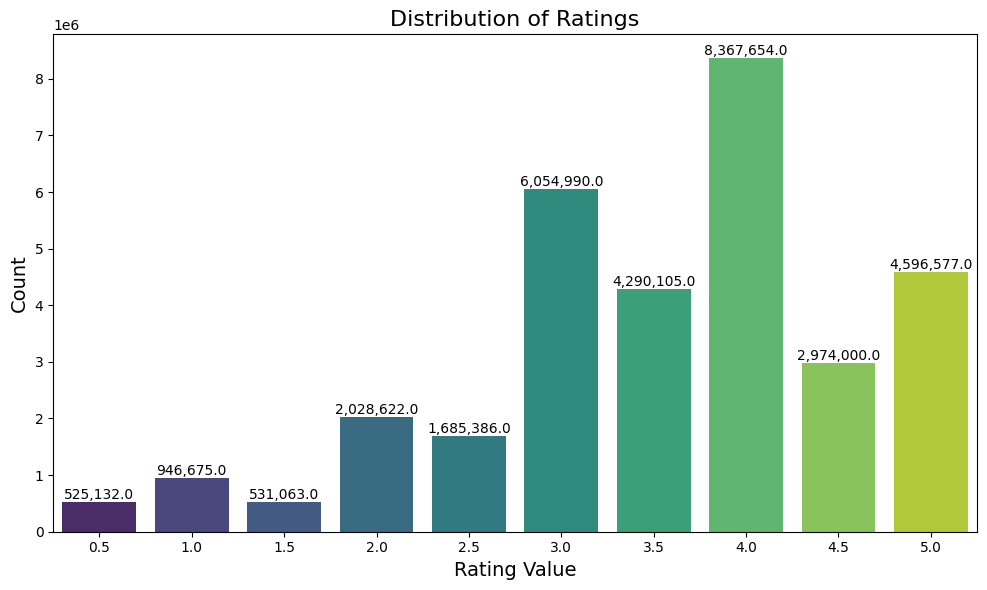

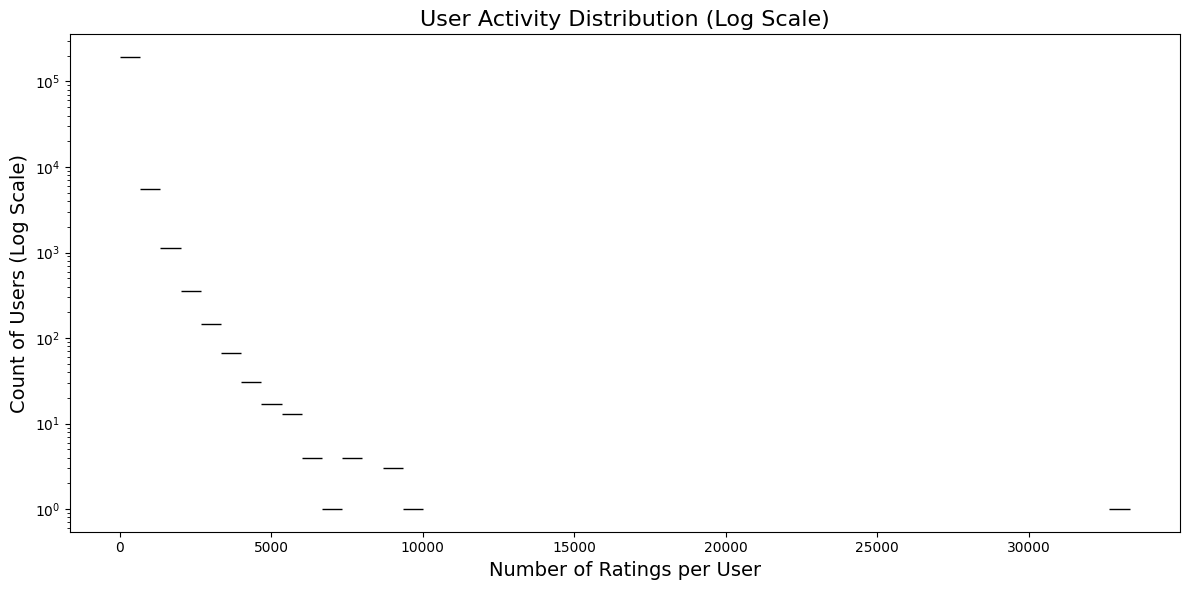

/tmp/ipykernel_63191/3788272752.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_movies, y='title', x='rating_count', palette='viridis')


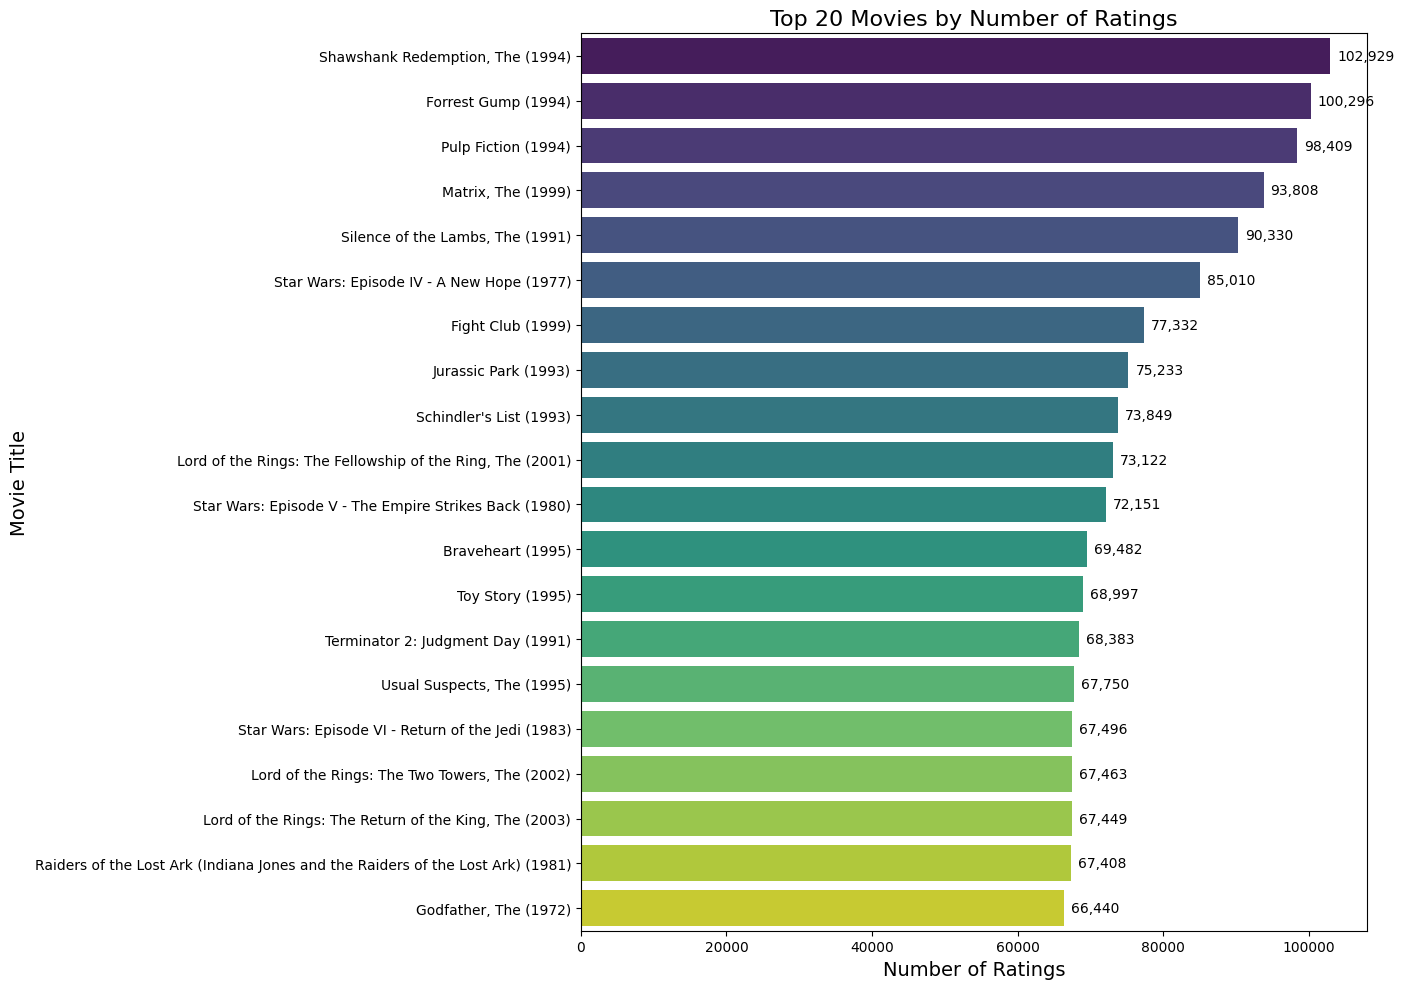

/tmp/ipykernel_63191/3788272752.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=genre_df, y='genre', x='count', palette='viridis')


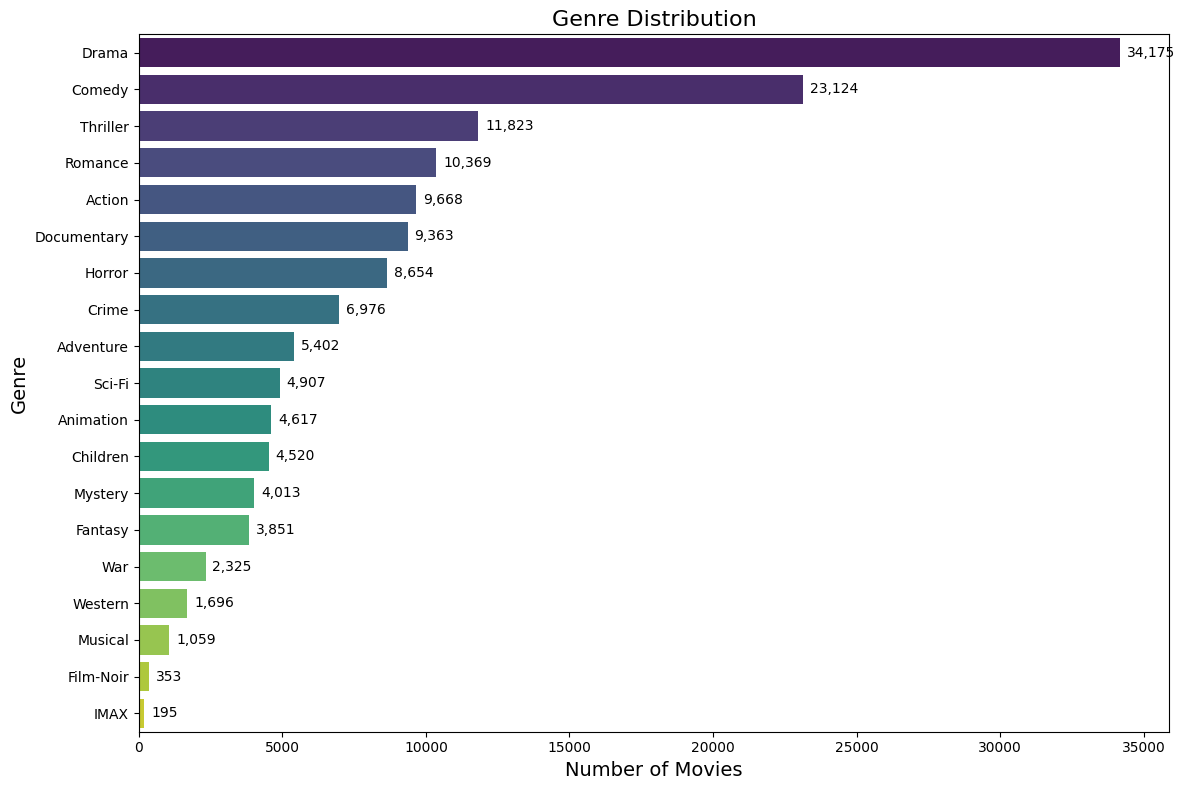

/tmp/ipykernel_63191/3788272752.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=genre_avg_df, y='genre', x='average_rating', palette='viridis')


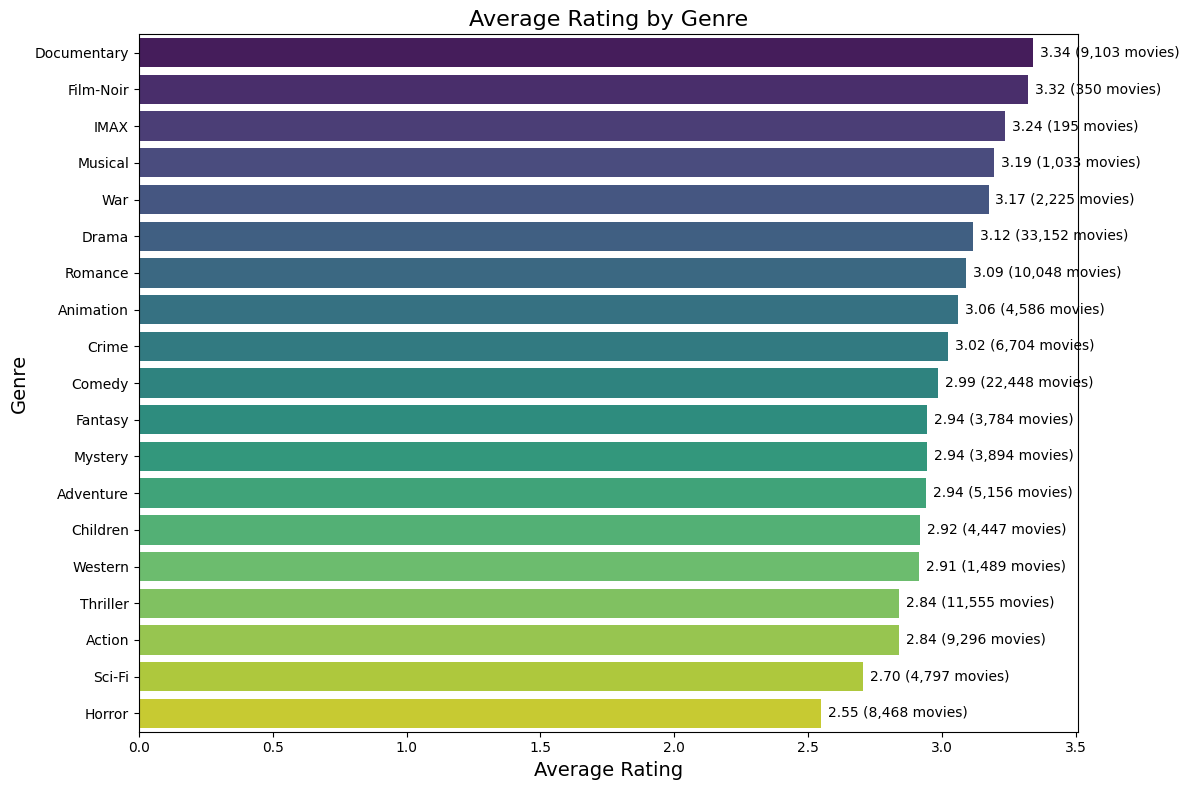

Visualizations saved to visualizations directory


In [8]:
visualization_analysis(ratings, movies)

# EDA and Pre-Process

In [9]:
def extract_year_from_title(title):
    """Extract year from movie title if present in format (YYYY)"""
    try:
        year = title.strip()[-5:-1]
        if year.isdigit():
            return int(year)
        return None
    except:
        return None


def preprocess_movies(movies):
    """
    Preprocess the movies dataframe
    - Extract year from title
    - Create one-hot encoded genre features
    """
    print("\nPreprocessing movies data...")
    
    # Make a copy to avoid modifying the original
    movies_processed = movies.copy()
    
    # Extract release year from title
    movies_processed['year'] = movies_processed['title'].apply(extract_year_from_title)
    
    # Remove year from title for cleaner display
    movies_processed['clean_title'] = movies_processed['title'].apply(
        lambda x: x.strip()[:-7].strip() if x.strip()[-6:-1].isdigit() else x
    )
    
    # One-hot encode genres
    # First, get all unique genres
    all_genres = set()
    for genre_list in movies_processed['genres'].str.split('|'):
        all_genres.update(genre_list)
    
    # Remove '(no genres listed)' if present
    if '(no genres listed)' in all_genres:
        all_genres.remove('(no genres listed)')
    
    # Create columns for each genre
    for genre in all_genres:
        movies_processed[f'genre_{genre}'] = movies_processed['genres'].apply(
            lambda x: 1 if genre in x.split('|') else 0
        )
    
    print(f"Movies data processed. Added {len(all_genres)} genre features and year extraction.")
    return movies_processed


def preprocess_ratings(ratings, min_interactions=10):
    """
    Preprocess the ratings dataframe
    - Filter users and movies with sufficient interactions
    - Compute user and item biases
    """
    print("\nPreprocessing ratings data...")
    
    # Make a copy
    ratings_processed = ratings.copy()
    
    # Calculate user and item interaction counts
    user_counts = ratings_processed['userId'].value_counts()
    movie_counts = ratings_processed['movieId'].value_counts()
    
    # Filter users and movies with at least min_interactions
    active_users = user_counts[user_counts >= min_interactions].index
    popular_movies = movie_counts[movie_counts >= min_interactions].index
    
    # Filter the ratings
    filtered_ratings = ratings_processed[
        (ratings_processed['userId'].isin(active_users)) & 
        (ratings_processed['movieId'].isin(popular_movies))
    ]
    
    # Calculate global average
    global_avg = filtered_ratings['rating'].mean()
    
    # Calculate user biases
    user_avgs = filtered_ratings.groupby('userId')['rating'].mean()
    user_biases = user_avgs - global_avg
    
    # Calculate item biases
    item_avgs = filtered_ratings.groupby('movieId')['rating'].mean()
    item_biases = item_avgs - global_avg
    
    # Create user and item feature dataframes
    user_features = pd.DataFrame({
        'userId': user_biases.index,
        'user_bias': user_biases.values,
        'rating_count': user_counts[user_biases.index].values
    })
    
    item_features = pd.DataFrame({
        'movieId': item_biases.index,
        'item_bias': item_biases.values,
        'rating_count': movie_counts[item_biases.index].values
    })
    
    print(f"Initial ratings: {len(ratings):,}")
    print(f"Filtered ratings: {len(filtered_ratings):,} ({len(filtered_ratings)/len(ratings)*100:.2f}%)")
    print(f"Active users: {len(active_users):,} (min {min_interactions} ratings)")
    print(f"Popular movies: {len(popular_movies):,} (min {min_interactions} ratings)")
    
    return filtered_ratings, user_features, item_features, global_avg

In [10]:
movies_processed = preprocess_movies(movies)


Preprocessing movies data...
Movies data processed. Added 19 genre features and year extraction.


In [11]:
filtered_ratings, user_features, item_features, global_avg = preprocess_ratings(
    ratings, min_interactions=min_interactions
)


Preprocessing ratings data...
Initial ratings: 32,000,204
Filtered ratings: 31,921,467 (99.75%)
Active users: 200,948 (min 5 ratings)
Popular movies: 43,884 (min 5 ratings)


In [12]:
def create_train_val_test_split(ratings, train_size=0.7, val_size=0.15, test_size=0.15, random_state=42):
    """
    Split ratings into training, validation, and test sets.
    Can be replaced with time-based splitting for more realistic evaluation.
    """
    print("\nCreating data splits...")
    
    # First split: training and temp (validation + test)
    train, temp = train_test_split(
        ratings, 
        train_size=train_size,
        random_state=random_state,
        stratify=ratings['userId'] % 10  # Stratify to ensure all users appear in train set
    )
    
    # Second split: validation and test from temp
    # Adjust validation size to get correct proportions
    adjusted_val_size = val_size / (val_size + test_size)
    val, test = train_test_split(
        temp, 
        train_size=adjusted_val_size,
        random_state=random_state,
        stratify=temp['userId'] % 10
    )
    
    print(f"Training set: {len(train):,} ratings ({len(train)/len(ratings)*100:.2f}%)")
    print(f"Validation set: {len(val):,} ratings ({len(val)/len(ratings)*100:.2f}%)")
    print(f"Test set: {len(test):,} ratings ({len(test)/len(ratings)*100:.2f}%)")
    
    # Check user coverage
    train_users = set(train['userId'].unique())
    val_users = set(val['userId'].unique())
    test_users = set(test['userId'].unique())
    
    print(f"Users in training set: {len(train_users):,}")
    print(f"Users in validation set: {len(val_users):,}")
    print(f"Users in test set: {len(test_users):,}")
    print(f"Users in validation set but not in training: {len(val_users - train_users)}")
    print(f"Users in test set but not in training: {len(test_users - train_users)}")
    
    return train, val, test


def create_sparse_matrices(train, val, test, user_map, movie_map):
    """
    Create sparse matrices for the different data splits.
    More efficient implementation for large datasets.
    """
    print("\nCreating sparse matrices (optimized)...")
    
    n_users = len(user_map)
    n_items = len(movie_map)
    
    # Pre-allocate COO format data
    # For train
    train_user_indices = []
    train_item_indices = []
    train_ratings = []
    
    # Process train data
    for user_id, movie_id, rating in zip(train['userId'], train['movieId'], train['rating']):
        if user_id in user_map and movie_id in movie_map:
            train_user_indices.append(user_map[user_id])
            train_item_indices.append(movie_map[movie_id])
            train_ratings.append(rating)
    
    # Create train matrix directly in COO format (more efficient)
    train_matrix = sparse.coo_matrix(
        (train_ratings, (train_user_indices, train_item_indices)), 
        shape=(n_users, n_items)
    ).tocsr()  # Convert to CSR for efficient operations
    
    # Process validation data
    val_user_indices = []
    val_item_indices = []
    val_ratings = []
    
    for user_id, movie_id, rating in zip(val['userId'], val['movieId'], val['rating']):
        if user_id in user_map and movie_id in movie_map:
            val_user_indices.append(user_map[user_id])
            val_item_indices.append(movie_map[movie_id])
            val_ratings.append(rating)
    
    val_matrix = sparse.coo_matrix(
        (val_ratings, (val_user_indices, val_item_indices)), 
        shape=(n_users, n_items)
    ).tocsr()
    
    # Process test data
    test_user_indices = []
    test_item_indices = []
    test_ratings = []
    
    for user_id, movie_id, rating in zip(test['userId'], test['movieId'], test['rating']):
        if user_id in user_map and movie_id in movie_map:
            test_user_indices.append(user_map[user_id])
            test_item_indices.append(movie_map[movie_id])
            test_ratings.append(rating)
    
    test_matrix = sparse.coo_matrix(
        (test_ratings, (test_user_indices, test_item_indices)), 
        shape=(n_users, n_items)
    ).tocsr()
    
    print(f"Created sparse matrices:")
    print(f"Training matrix: {train_matrix.shape}, nonzero: {train_matrix.nnz}")
    print(f"Validation matrix: {val_matrix.shape}, nonzero: {val_matrix.nnz}")
    print(f"Test matrix: {test_matrix.shape}, nonzero: {test_matrix.nnz}")
    
    return train_matrix, val_matrix, test_matrix


def save_processed_data(output_dir, train, val, test, movies_processed, 
                       user_features, item_features, user_map, movie_map):
    """
    Save all processed data to disk.
    """
    print("\nSaving processed data...")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save dataframes
    train.to_csv(os.path.join(output_dir, 'train_ratings.csv'), index=False)
    val.to_csv(os.path.join(output_dir, 'val_ratings.csv'), index=False)
    test.to_csv(os.path.join(output_dir, 'test_ratings.csv'), index=False)
    
    movies_processed.to_csv(os.path.join(output_dir, 'movies_processed.csv'), index=False)
    user_features.to_csv(os.path.join(output_dir, 'user_features.csv'), index=False)
    item_features.to_csv(os.path.join(output_dir, 'item_features.csv'), index=False)
    
    # Save ID mappings
    user_map_df = pd.DataFrame({
        'userId': list(user_map.keys()),
        'matrix_idx': list(user_map.values())
    })
    movie_map_df = pd.DataFrame({
        'movieId': list(movie_map.keys()),
        'matrix_idx': list(movie_map.values())
    })
    
    user_map_df.to_csv(os.path.join(output_dir, 'user_id_map.csv'), index=False)
    movie_map_df.to_csv(os.path.join(output_dir, 'movie_id_map.csv'), index=False)
    
    print(f"All processed data saved to {output_dir}")

In [13]:
train, val, test = create_train_val_test_split(filtered_ratings)


Creating data splits...
Training set: 22,345,026 ratings (70.00%)
Validation set: 4,788,220 ratings (15.00%)
Test set: 4,788,221 ratings (15.00%)
Users in training set: 200,948
Users in validation set: 200,110
Users in test set: 200,078
Users in validation set but not in training: 0
Users in test set but not in training: 0


In [14]:
user_ids = sorted(user_features['userId'].unique())
movie_ids = sorted(item_features['movieId'].unique())

user_map = {user_id: i for i, user_id in enumerate(user_ids)}
movie_map = {movie_id: i for i, movie_id in enumerate(movie_ids)}

# Create sparse matrices using optimized function
train_matrix, val_matrix, test_matrix = create_sparse_matrices(
    train, val, test, user_map, movie_map
)


Creating sparse matrices (optimized)...
Created sparse matrices:
Training matrix: (200948, 43884), nonzero: 22345026
Validation matrix: (200948, 43884), nonzero: 4788220
Test matrix: (200948, 43884), nonzero: 4788221


In [15]:
output_dir="processed_data"
save_processed_data(
    output_dir, train, val, test, movies_processed, 
    user_features, item_features, user_map, movie_map
)


Saving processed data...
All processed data saved to processed_data


In [16]:
result = {
    'train_matrix': train_matrix,
    'val_matrix': val_matrix,
    'test_matrix': test_matrix,
    'user_map': user_map,
    'movie_map': movie_map,
    'user_features': user_features,
    'item_features': item_features,
    'movies_processed': movies_processed,
    'global_avg': global_avg
}

# Saving Sparse matrix

In [17]:
def save_sparse_matrices(train_matrix, val_matrix, test_matrix, output_dir):
    """
    Save sparse matrices in compressed .npz format
    """
    print("\nSaving sparse matrices...")
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Save matrices in compressed format
    sparse.save_npz(os.path.join(output_dir, 'train_matrix.npz'), train_matrix)
    sparse.save_npz(os.path.join(output_dir, 'val_matrix.npz'), val_matrix)
    sparse.save_npz(os.path.join(output_dir, 'test_matrix.npz'), test_matrix)
    
    print(f"Sparse matrices saved to {output_dir}")
sparse_dir = os.path.join(output_dir, 'sparse_matrices')
save_sparse_matrices(train_matrix, val_matrix, test_matrix, sparse_dir)


Saving sparse matrices...
Sparse matrices saved to processed_data/sparse_matrices
